#Predicting Bitcoin Price

##Data Collection and Exploration

I am interested in studying the market behavior of [bitcoin](https://en.wikipedia.org/wiki/Bitcoin), a form of digital currency growing in popularity and with the potential to revolutionize how we conduct financial transactions.

Specifically, I would like to identify important predictors of bitcoin price. I will collect daily bitcoin transaction records from the [Bitcoin Block Explorer](https://blockchain.info/), including USD market price averaged from popular bitcoin exchanges. In addition, I will gather bitcoin-related results from [Google Trends](https://www.google.com/trends/explore#q=bitcoin) for the same time period. I will be analyzing the relationship of different features with bitcoin price using linear regression and time series analysis.

This project will contribute to our general understanding of bitcoin as an alternative currency, and the potential impact of the Bitcoin blockchain technology.

### Imports

In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import urllib
import pandas as pd
import numpy as np
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# enable inline plots
%matplotlib inline

### Raw Data Collection

Scrape daily bitcoin chart data from [Blockchain](https://blockchain.info/) explorer using the custom script below. Save all datasets as csv files. Additional documentation on the data sets can be found on [Bitcoin Charts](https://blockchain.info/charts).

In [3]:
url = "http://blockchain.info/charts"
page = urllib.urlopen(url).read()
soup = BeautifulSoup(page)
charts = []
chart_names = []

for a in soup.findAll('a', href=True):
    if a['href'].startswith('/charts/'):
        charts.append(a['href'])
        chart_names.append(a.text)

params = "?showDataPoints=false&timespan=all&show_header=true&daysAverageString=1&scale=0&format=csv&address="


chart_url = []
for c in charts:
    str = "http://blockchain.info/" + c  + params
    chart_url.append(str)

filenames = []
for n in chart_names:
    str = n.replace(' ', '_') + ".csv"
    filenames.append(str)

for i in range(len(charts)):
    print(chart_url[i])
    print(filenames[i])
    urllib.urlretrieve(chart_url[i], filenames[i])

http://blockchain.info//charts/total-bitcoins?showDataPoints=false&timespan=all&show_header=true&daysAverageString=1&scale=0&format=csv&address=
Total_Bitcoins_in_Circulation.csv
http://blockchain.info//charts/market-cap?showDataPoints=false&timespan=all&show_header=true&daysAverageString=1&scale=0&format=csv&address=
Market_Capitalization.csv
http://blockchain.info//charts/transaction-fees?showDataPoints=false&timespan=all&show_header=true&daysAverageString=1&scale=0&format=csv&address=
Total_Transaction_Fees.csv
http://blockchain.info//charts/transaction-fees-usd?showDataPoints=false&timespan=all&show_header=true&daysAverageString=1&scale=0&format=csv&address=
Transaction_Fees_in_USD.csv
http://blockchain.info//charts/network-deficit?showDataPoints=false&timespan=all&show_header=true&daysAverageString=1&scale=0&format=csv&address=
Network_Deficit_Per_Day.csv
http://blockchain.info//charts/n-transactions?showDataPoints=false&timespan=all&show_header=true&daysAverageString=1&scale=0&fo

### Merging Data Sets

Create the bitcoin data frame:

In [4]:
bitcoin = pd.DataFrame()

Define method to retrieve data from csv files, assign column names and convert the date field into the target format.

In [5]:
def get_data(path, field):
    result = pd.read_csv(path, header=None)
    result.rename(columns={0:'date', 1:field}, inplace=True)
    
    #convert dates: from 03/01/2009 18:15:05 to 2009-01-03
    result.date = pd.to_datetime(result.date, format="%d/%m/%Y %H:%M:%S")
    
    return result

Define method to merge the data sets based on the date field.

In [6]:
def merge_columns(main, other):
    result = pd.merge(left=main,right=other, how='outer', left_on='date', right_on='date')
    
    return result

Read in the average block size data. This is average size of all block headers and transactions in MB.

In [7]:
path = 'Average_Block_Size.csv'
field = 'block_size'

block_size = get_data(path, field)

Read in the average number of transactions per block.

In [8]:
path = 'Average_Number_of_Transactions_per_Block.csv'
field = 'block_transactions'
block_transactions = get_data(path, field)

Merge the block transactions data set with the block size data based on dates.

In [9]:
bitcoin = merge_columns(block_size, block_transactions)

Read in the blockchain size and merge with the bitcoin data frame. This is total size of all block headers and transactions in MB. The block chain is a shared public ledger where all confirmed bitcoin transactions are recorded.

In [10]:
path = 'Blockchain_Size.csv'
field = 'blockchain_size'
blockchain_size = get_data(path, field)

bitcoin = merge_columns(bitcoin, blockchain_size)

Read in the cost per transaction and merge with the data frame. This is the bitcoin miners revenue divided by the number of transactions for the same period.

In [11]:
path = 'Cost_per_Transaction.csv'
field = 'transaction_cost'
transaction_cost = get_data(path, field)

bitcoin = merge_columns(bitcoin, transaction_cost)

Read in the cost % per transaction volume and merge with the data frame. This is miners revenue as percentage of the transaction volume.

In [12]:
path = 'Cost_%_of_Transaction_Volume.csv'
field = 'percent_cost'
percent_cost = get_data(path, field)

bitcoin = merge_columns(bitcoin, percent_cost)

Read in the difficulty level and merge with the data frame. This is a unit-less measure of how difficult it is to find a new block compared to the easiest it can ever be.

In [13]:
path = 'Difficulty.csv'
field = 'difficulty'
difficulty = get_data(path, field)

bitcoin = merge_columns(bitcoin, difficulty)

Read in the estimated transaction volume and merge. According to the Bitcoin Block Explorer documentation, this is similar to the total output volume with the addition of an algorithm which attempts to remove change from the total value and may be a more accurate reflection of the true transaction volume.

In [14]:
path = 'Estimated_Transaction_Volume.csv'
field = 'transaction_vol'
transaction_vol = get_data(path, field)

bitcoin = merge_columns(bitcoin, transaction_vol)

Read in the hash rate and merge. This is the estimated number of giga (billion) hashes per second the bitcoin network is performing. Bitcoin mining involves competing to generate random SHA-256 hashes until a hash with certain suitable properties (starts with a specific number of 0 bits) is found. More information on bitcoin hashing algorithm can be found in [Bitcoin Wiki](https://en.bitcoin.it/wiki/Block_hashing_algorithm).



In [15]:
path = 'Hash_Rate.csv'
field = 'hash_rate'
hash_rate = get_data(path, field)

bitcoin = merge_columns(bitcoin, hash_rate)

Read in market capitalization and merge. This is the total number of bitcoins in circulation multiplied by the market price in USD.

In [16]:
path = 'Market_Capitalization.csv'
field = 'market_cap'
market_cap = get_data(path, field)

bitcoin = merge_columns(bitcoin, market_cap)

Read in median transaction time and merge. This is the median time taken for transactions with a fee to be accepted into a block to be recorded in the blockchain ledger.


In [17]:
path = 'Median_Transaction_Confirmation_Time_(With_Fee_Only).csv'
field = 'confirmation_time'
confirmation_time = get_data(path, field)

bitcoin = merge_columns(bitcoin, confirmation_time)

Read in miners revenue and merge. This is calculated from the number of bitcoins mined per day plus transaction fees then multiplied by the market price in USD. A new bitcoin is mined every 10 minutes on average.


In [18]:
path = 'Miners_Revenue.csv'
field = 'miners_revenue'
miners_revenue = get_data(path, field)

bitcoin = merge_columns(bitcoin, miners_revenue)

Read in the network deficit and merge. This shows difference between transaction fees and cost of bitcoin mining.


In [19]:
path = 'Network_Deficit_Per_Day.csv'
field = 'deficit'
deficit = get_data(path, field)

bitcoin = merge_columns(bitcoin, deficit)

Read in the number of orphaned blocks and merge. This is the number of blocks mined per day not part of the main chain but were instead part of a fork that was discarded. According to [Ghash.io](http://mining.ghash.io/orphan-block/), "[Orphan] blocks are created naturally by multiple miners when they find blocks at similar times which then leads to only one of the blocks being confirmed and stored in the blockchain. If a block is rejected it will be redeemed as an invalid block, and the block will not remain in the blockchain’s history nor will it reward the finder with the coins it contained."


In [20]:
path = 'Number_of_Orphaned_Blocks.csv'
field = 'orphaned_blocks'
orphaned_blocks = get_data(path, field)

bitcoin = merge_columns(bitcoin, orphaned_blocks)

Read in number of transactions and merge. This is the total number of unique bitcoin transactions per day.


In [21]:
path = 'Number_of_Transactions.csv'
field = 'all_transactions'
all_transactions = get_data(path, field)

bitcoin = merge_columns(bitcoin, all_transactions)

Read in number of transactions excluding chains of various lengths. According to [Bitcoin Block Explorer](https://blockchain.info/charts), this is the "total number of bitcoin transactions per day excluding those part of long chain transaction chains. There are many legitimate reasons to create long transaction chains however they may also be caused by coin mixing or possible attempts to manipulate transaction volume." 

In [22]:
path = 'Number_of_Transactions_Excluding_Chains_Longer_Than_10,000.csv'
field = 'sub10000_transactions'
sub10000_transactions = get_data(path, field)

bitcoin = merge_columns(bitcoin, sub10000_transactions)

In [23]:
path = 'Number_of_Transactions_Excluding_Chains_Longer_Than_10.csv'
field = 'sub10_transactions'
sub10_transactions = get_data(path, field)

bitcoin = merge_columns(bitcoin, sub10_transactions)

In [24]:
path = 'Number_of_Transactions_Excluding_Chains_Longer_Than_100.csv'
field = 'sub100_transactions'
sub100_transactions = get_data(path, field)

bitcoin = merge_columns(bitcoin, sub100_transactions)


In [25]:
path = 'Number_of_Transactions_Excluding_Chains_Longer_Than_1000.csv'
field = 'sub1000_transactions'
sub1000_transactions = get_data(path, field)

bitcoin = merge_columns(bitcoin, sub1000_transactions)

In [26]:
path = 'Number_of_Transactions_excluding_Long_Chains.csv'
field = 'short_transactions'
short_transactions = get_data(path, field)

bitcoin = merge_columns(bitcoin, short_transactions)

Read in the number of transactions excluding popular addresses and merge. This is the total number of unique bitcoin transactions per day except for transactions involving the 100 most popular addresses.

In [27]:
path = 'Number_of_Transactions_excluding_Popular_Addresses.csv'
field = 'nonpopular_transactions'
nonpopular_transactions = get_data(path, field)

bitcoin = merge_columns(bitcoin, nonpopular_transactions)

Read in the number of unique bitcoin addresses used per day and merge. This may be used as an indirect indicator of how widely bitcoin is being used over time.

In [28]:
path = 'Number_of_Unique_Bitcoin_Addresses_Used.csv'
field = 'unique_addresses'
unique_addresses = get_data(path, field)

bitcoin = merge_columns(bitcoin, unique_addresses)

Read in the total bitcoins and merge. This is the historical total number of bitcoins which have been mined.

In [29]:
path = 'Total_Bitcoins_in_Circulation.csv'
field = 'total_bitcoins'
total_bitcoins = get_data(path, field)

bitcoin = merge_columns(bitcoin, total_bitcoins)

Read in the total number of transactions and merge. This is the total number of unique bitcoin transactions over time.

In [30]:
path = 'Total_Number_of_transactions.csv'
field = 'total_transactions'
total_transactions = get_data(path, field)

bitcoin = merge_columns(bitcoin, total_transactions)

Read in the total transaction fees and merge. This is the total BTC value of transaction fees miners earn per day.

In [31]:
path = 'Total_Transaction_Fees.csv'
field = 'transaction_fees'
transaction_fees = get_data(path, field)

bitcoin = merge_columns(bitcoin, transaction_fees)

Read in the total output volume and merge. This is the total value of all transaction outputs per day, including coins that were returned to the sender as change.

In [32]:
path = 'Total_Output_Volume.csv'
field = 'output_vol'
output_vol = get_data(path, field)

bitcoin = merge_columns(bitcoin, output_vol)

Read in the ratio of trade volume to transaction volume and merge. This is the relationship between BTC transaction volume and USD exchange volume.

In [33]:
path = 'Trade_Volume_vs_Transaction_Volume_Ratio.csv'
field = 'trade_transaction_ratio'
trade_transaction_ratio = get_data(path, field)

bitcoin = merge_columns(bitcoin, trade_transaction_ratio)

Read in the daily transaction fees and merge. This is the total BTC value of transaction fees miners earn per day.

In [34]:
path = 'Transaction_Fees_in_USD.csv'
field = 'transaction_fees_usd'
transaction_fees_usd = get_data(path, field)

bitcoin = merge_columns(bitcoin, transaction_fees_usd)

Read in the exchange trade volume and merge. This is the USD trade volume from the top bitcoin exchanges.

In [35]:
path = 'USD_Exchange_Trade_Volume.csv'
field = 'exchange_vol_usd'
exchange_vol_usd = get_data(path, field)

bitcoin = merge_columns(bitcoin, exchange_vol_usd)

Read in market price in USD and merge. This will be the basis of the outcome variable 'next_day' which is the market price of bitcoin the following day. This column will be added later. 

In [36]:
path = 'Market_Price_(USD).csv'
field = 'price_usd'
price_usd =  get_data(path, field)
price_usd['date'] = pd.DatetimeIndex(price_usd.date).normalize()
print price_usd.tail()

           date  price_usd
2560 2016-01-07     453.71
2561 2016-01-08     447.04
2562 2016-01-09     450.15
2563 2016-01-10     446.24
2564 2016-01-11     451.09


In [37]:
bitcoin_price = pd.DataFrame()
# store the date in yyyy-mm-dd format
bitcoin['date'] = pd.DatetimeIndex(bitcoin.date).normalize()

bitcoin_price = merge_columns(bitcoin, price_usd)

### Data exploration

Plot bitcoin block data over time.

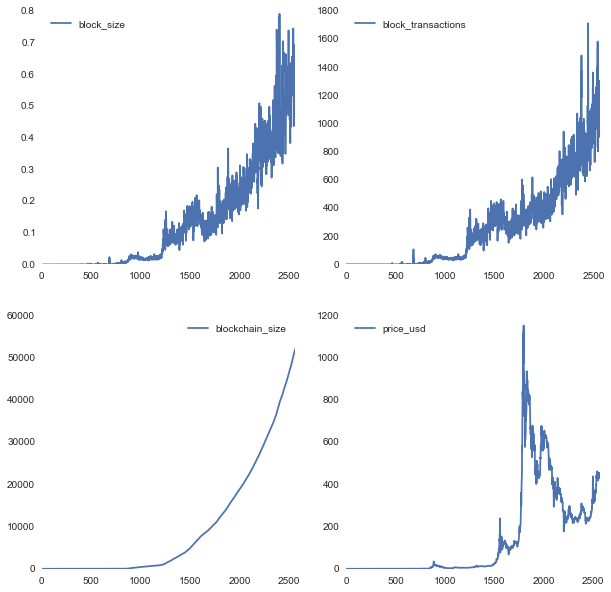

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
block_size.plot(ax=axes[0,0])
block_transactions.plot(ax=axes[0,1])
blockchain_size.plot(ax=axes[1,0])
price_usd.plot(ax=axes[1,1])

Plot transaction data over time.

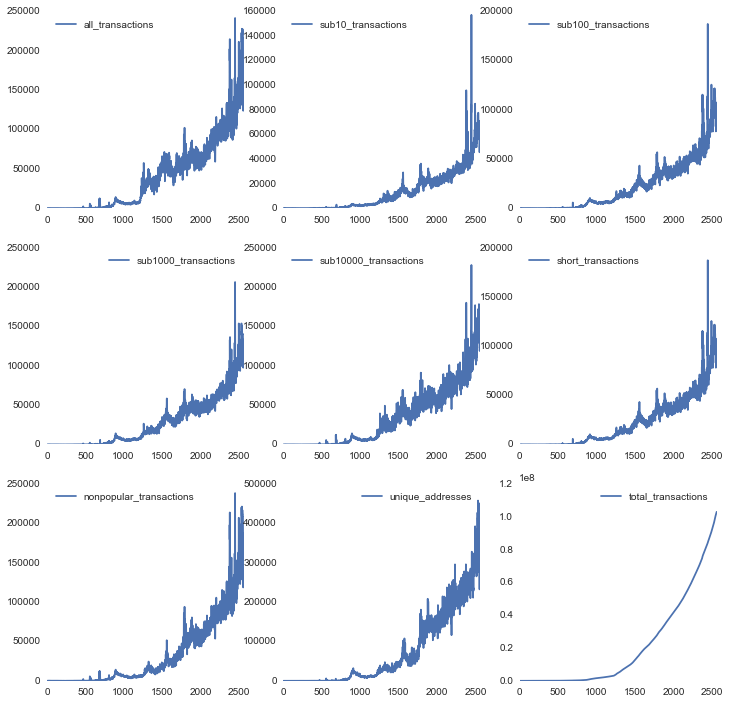

In [39]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12,12))

all_transactions.plot(ax=axes[0,0])
sub10_transactions.plot(ax=axes[0,1])
sub100_transactions.plot(ax=axes[0,2])
sub1000_transactions.plot(ax=axes[1,0])
sub10000_transactions.plot(ax=axes[1,1])
short_transactions.plot(ax=axes[1,2])
nonpopular_transactions.plot(ax=axes[2,0])
unique_addresses.plot(ax=axes[2,1])
total_transactions.plot(ax=axes[2,2])


Plot cost and revenues over time

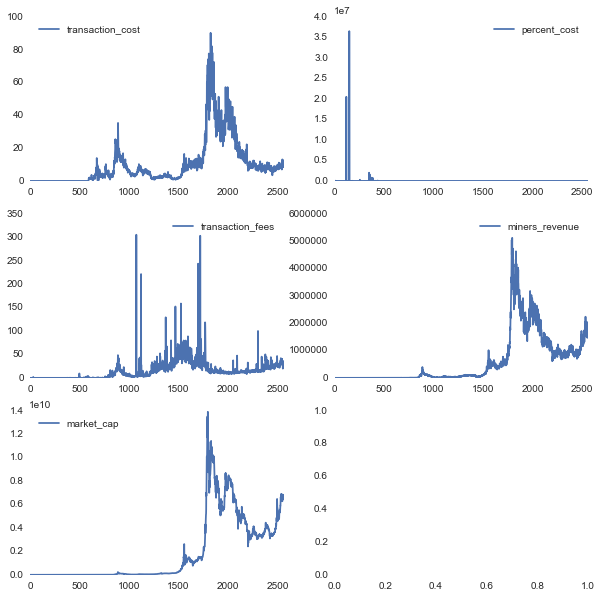

In [40]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

transaction_cost.plot(ax=axes[0,0])
percent_cost.plot(ax=axes[0,1])
transaction_fees.plot(ax=axes[1,0])
miners_revenue.plot(ax=axes[1,1])
market_cap.plot(ax=axes[2,0])


Plot volume and trade data over time.

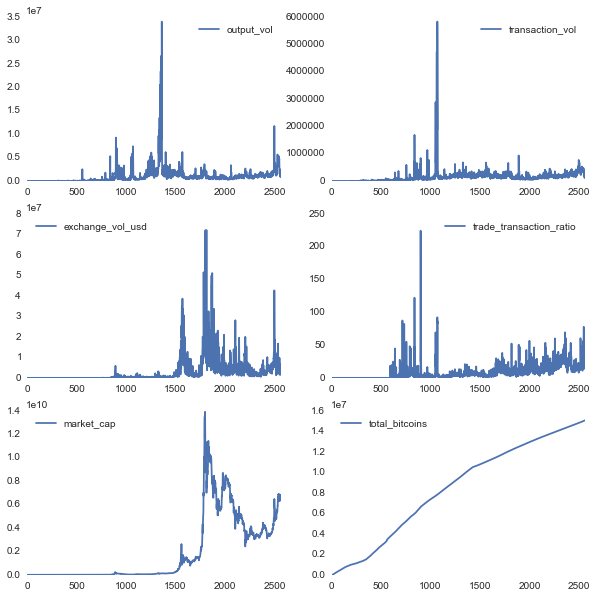

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

output_vol.plot(ax=axes[0,0])
transaction_vol.plot(ax=axes[0,1])
exchange_vol_usd.plot(ax=axes[1,0])
trade_transaction_ratio.plot(ax=axes[1,1])
market_cap.plot(ax=axes[2,0])
total_bitcoins.plot(ax=axes[2,1])

Plot technical statistics over time.

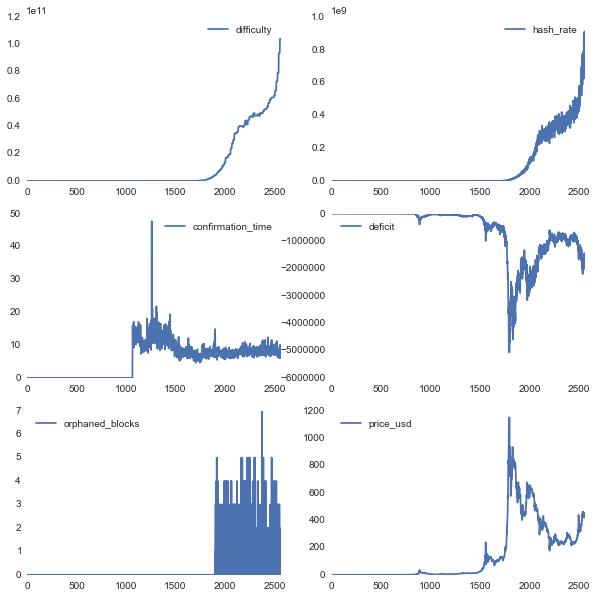

In [42]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

difficulty.plot(ax=axes[0,0])
hash_rate.plot(ax=axes[0,1])
confirmation_time.plot(ax=axes[1,0])
deficit.plot(ax=axes[1,1])
orphaned_blocks.plot(ax=axes[2,0])
price_usd.plot(ax=axes[2,1])


Plot cumulative values over time.

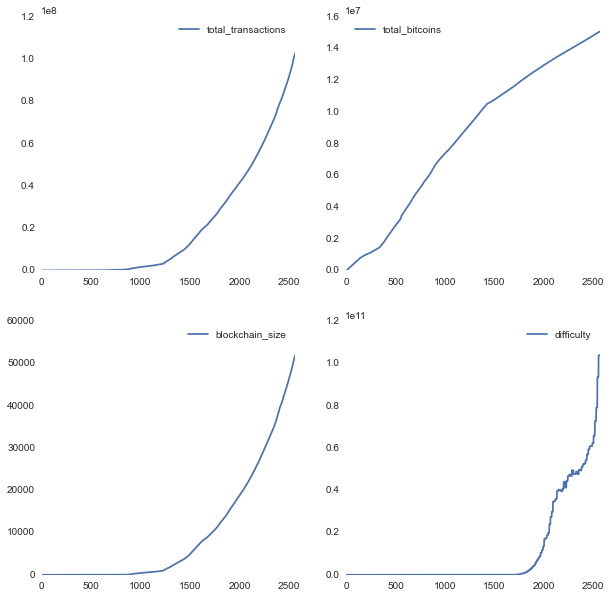

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

total_transactions.plot(ax=axes[0,0])
total_bitcoins.plot(ax=axes[0,1])
blockchain_size.plot(ax=axes[1,0])
difficulty.plot(ax=axes[1,1])

Compare plots of trade_transaction_ratio * 10 and price_usd.
The ratio indicates the relationship between bitcoin transaction volume and USD exchange volume and may have some predictive value.

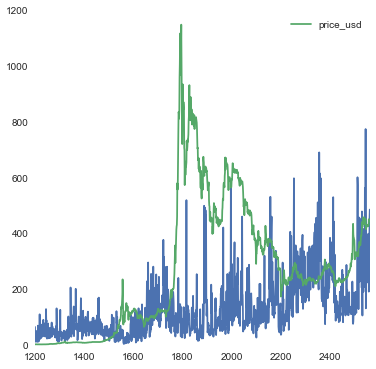

In [44]:
ttr10 = trade_transaction_ratio
ttr10 = ttr10['trade_transaction_ratio'].map(lambda x: x*10)
ax = ttr10[1200:].plot(figsize=(6,6))
price_usd[1200:].plot(ax=ax)

Remove null values from bitcoin_price data frame.

In [45]:
bitcoin_price.block_transactions = bitcoin_price.block_transactions.dropna()
bitcoin_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2565 entries, 0 to 2564
Data columns (total 30 columns):
date                       2565 non-null datetime64[ns]
block_size                 2565 non-null float64
block_transactions         2560 non-null float64
blockchain_size            2565 non-null float64
transaction_cost           2565 non-null float64
percent_cost               2565 non-null float64
difficulty                 2565 non-null float64
transaction_vol            2565 non-null float64
hash_rate                  2565 non-null float64
market_cap                 2565 non-null float64
confirmation_time          2565 non-null float64
miners_revenue             2565 non-null float64
deficit                    2565 non-null float64
orphaned_blocks            2565 non-null float64
all_transactions           2565 non-null float64
sub10000_transactions      2565 non-null float64
sub10_transactions         2565 non-null float64
sub100_transactions        2565 non-null float64
sub1

Create a scatterplot to investigate the possible relationships among the features, with the goal of identifying outliers, possible multicollinearity and non-linear relationships.

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


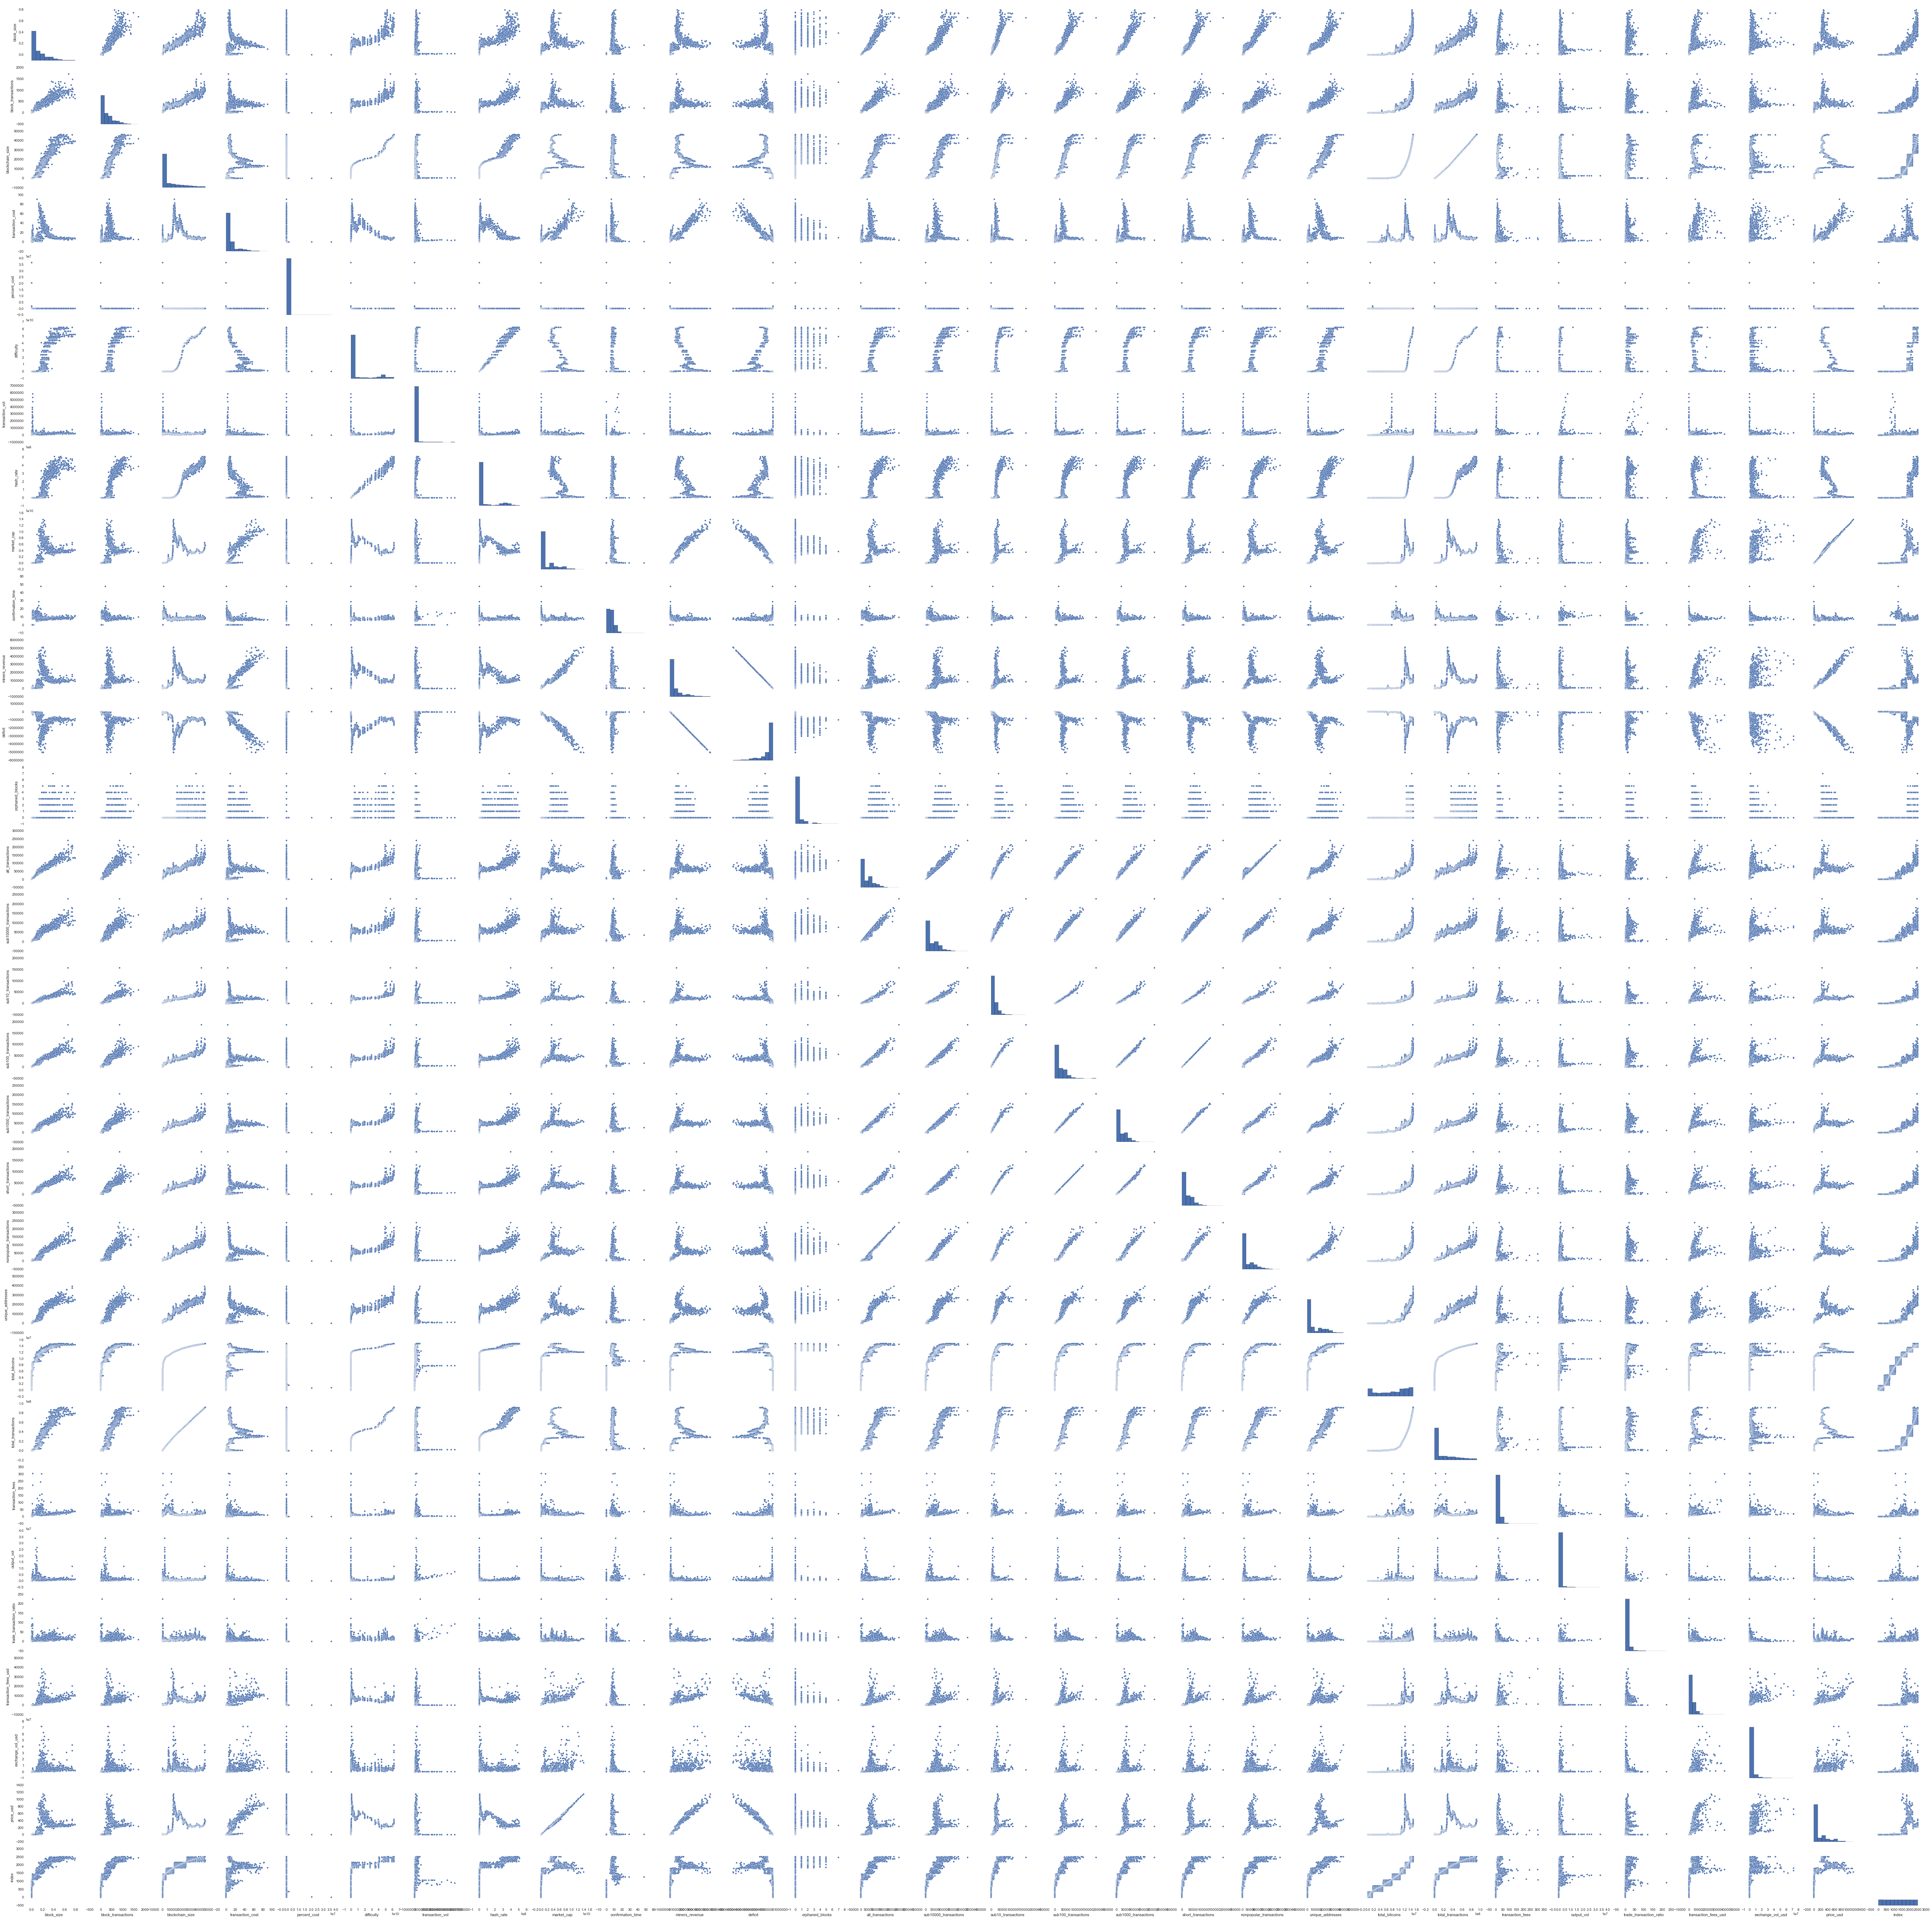

In [56]:
g = sns.pairplot(bitcoin_price)

Display the features in the merged data set.

In [47]:
for col in bitcoin_price.columns:
    print col    

date
block_size
block_transactions
blockchain_size
transaction_cost
percent_cost
difficulty
transaction_vol
hash_rate
market_cap
confirmation_time
miners_revenue
deficit
orphaned_blocks
all_transactions
sub10000_transactions
sub10_transactions
sub100_transactions
sub1000_transactions
short_transactions
nonpopular_transactions
unique_addresses
total_bitcoins
total_transactions
transaction_fees
output_vol
trade_transaction_ratio
transaction_fees_usd
exchange_vol_usd
price_usd


### Export Data Set For Analysis

In [ ]:
bitcoin_price['trading_day'] = bitcoin_price['date']
bitcoin_price.to_csv('bitcoin_price.csv')

# Output is bitcoin_price.csv which will be analyzed in the 'Data Analysis' notebook.